In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'random/'
features = 'orbsummaryfeaturesxgbNorbits10000.0Nout1000window10/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['t_final_short' 'avg_beta12' 'std_beta12' 'min_beta12' 'max_beta12'
 'avg_beta23' 'std_beta23' 'min_beta23' 'max_beta23' 'avg_a1' 'std_a1'
 'max_a1' 'min_a1' 'norm_std_a1' 'norm_max_a1' 'norm_std_window10_a1'
 'norm_max_window10_a1' 'avg_e1' 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1'
 'norm_max_e1' 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1'
 'std_inc1' 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window10_inc2' 'avg_eH2' 'std_eH2' '

In [3]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
24995,0024995.bin,1.843086e+04,5.927632e+04,False
24996,0024996.bin,1.868259e+03,2.336571e+03,False
24997,0024997.bin,6.939732e+04,1.870889e+04,False
24998,0024998.bin,3.230628e+04,2.883785e+04,False
24999,0024999.bin,1.000024e+09,1.000024e+09,True


In [5]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = labels[labels['instability_time'] > 1.e4]['Stable']
X = dataset[labels['instability_time'] > 1.e4][features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.396181,0.478983,0.000385,0.001217,0.000368,0.000617,0.000827,0.002327,0.000810,0.001389,...,-1.370529e-12,7.153530e-12,8.483687,0.056762,8.317693,8.557411,15.793822,0.092564,15.573864,16.067016
1,1.047261,0.837314,0.000617,0.002269,0.000261,0.000739,0.000198,0.000387,0.000247,0.000332,...,8.009972e-13,-1.378565e-12,8.415867,0.034972,8.302231,8.534979,15.313549,0.036618,15.246089,15.372485
2,0.439385,0.490559,0.001941,0.004587,0.001504,0.002501,0.002291,0.004981,0.001832,0.003063,...,-4.224861e-12,9.052250e-13,3.570380,0.131639,3.273783,3.776337,25.109709,0.137757,24.892952,25.409039
3,0.435169,0.557506,0.000025,0.000116,0.000026,0.000075,0.000015,0.000039,0.000009,0.000017,...,-5.223709e-14,2.302459e-13,18.513765,0.003294,18.500432,18.520812,19.142522,0.007732,19.124105,19.157782
5,3.273793,1.859880,0.000318,0.000738,0.000282,0.000756,0.000225,0.000586,0.000196,0.000519,...,2.145608e-13,-6.422160e-14,28.341368,0.042350,28.293751,28.443846,22.453980,0.014762,22.411693,22.477381


In [6]:
X.shape

(17522, 37)

In [7]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [8]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [9]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [10]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9486150999999999                                  
ERROR                                               
0.0040355124089027795                               
HOLDOUT SCORE                                       
0.963790684206172                                   
SCORE:                                                                        
0.9290296400000001                                                            
ERROR                                                                         
0.0038948268254301102                                                         
HOLDOUT SCORE                                                                 
0.9490697443534375                                                            
SCORE:                                                                        
0.8772002599999998                                                            
ERROR                                             

0.005430199228363462                                                           
HOLDOUT SCORE                                                                  
0.9187570116654257                                                             
SCORE:                                                                         
0.93355824                                                                     
ERROR                                                                          
0.005777861403161629                                                           
HOLDOUT SCORE                                                                  
0.9536108215438074                                                             
SCORE:                                                                         
0.94683662                                                                     
ERROR                                                                          
0.004184960837931289                    

0.004402560075246666                                                            
HOLDOUT SCORE                                                                   
0.9647538677918424                                                              
SCORE:                                                                          
0.94853372                                                                      
ERROR                                                                           
0.004902639622308323                                                            
HOLDOUT SCORE                                                                   
0.9646931413915778                                                              
SCORE:                                                                          
0.94703702                                                                      
ERROR                                                                           
0.004557664469289333        

In [11]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.18410110716753678,
 'x_max_depth': 12,
 'x_min_child': 4.0,
 'x_pos_weight': 4.335947645987986,
 'x_subsample': 0.9589462113081548,
 'x_tree_colsample': 0.6342754116524321}

In [12]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.960292+0.00113491	test-auc:0.919125+0.00742204
[1]	train-auc:0.977185+0.00163186	test-auc:0.936364+0.00547226
[2]	train-auc:0.983095+0.00134883	test-auc:0.942915+0.00574146
[3]	train-auc:0.986064+0.00116316	test-auc:0.947488+0.00464341
[4]	train-auc:0.988253+0.00107414	test-auc:0.950759+0.00346268
[5]	train-auc:0.99024+0.000637785	test-auc:0.95278+0.00338695
[6]	train-auc:0.991404+0.000427306	test-auc:0.954557+0.00441993
[7]	train-auc:0.99249+0.00030568	test-auc:0.955684+0.00488033
[8]	train-auc:0.993529+0.00035147	test-auc:0.957044+0.00457427
[9]	train-auc:0.994181+0.000311706	test-auc:0.958074+0.00436182
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.960292       0.001135       0.919125      0.007422
1        0.977185       0.001632       0.936364      0.005472
2        0.983095       0.001349       0.942915      0.005741
3        0.986064       0.001163       0.947488      0.004643
4        0.988253       0.001074       0.950759      0.00346

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.9716088381444127


In [13]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9710725572929595
0.9775199459884253


In [14]:
print(best)

{'x_learning_rate': 0.18410110716753678, 'x_max_depth': 12, 'x_min_child': 4.0, 'x_pos_weight': 4.335947645987986, 'x_subsample': 0.9589462113081548, 'x_tree_colsample': 0.6342754116524321}


Text(0.5, 1.0, 'ROC curve (AUC = 0.971)')

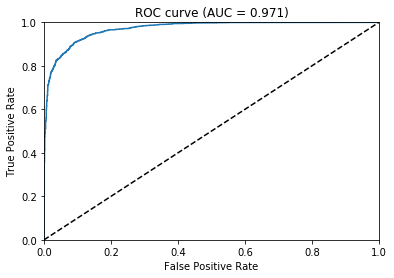

In [15]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [16]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.0004922175430692732, recall = 1.0, precision = 0.6162246489859594
Threshold 0.0005363262025639415, recall = 0.999493670886076, precision = 0.618808777429467
Threshold 0.000616104225628078, recall = 0.999493670886076, precision = 0.6217322834645669
Threshold 0.0006639822968281806, recall = 0.999493670886076, precision = 0.6246835443037975
Threshold 0.0007076480542309582, recall = 0.999493670886076, precision = 0.6276629570747218
Threshold 0.000763018848374486, recall = 0.999493670886076, precision = 0.6306709265175718
Threshold 0.0008402522071264684, recall = 0.999493670886076, precision = 0.6337078651685393
Threshold 0.0008993354858830571, recall = 0.999493670886076, precision = 0.636774193548387
Threshold 0.0010038649197667837, recall = 0.999493670886076, precision = 0.639870340356564
Threshold 0.0010891291312873363, recall = 0.999493670886076, precision = 0.6429967426710098
Threshold 0.0011494357604533434, recall = 0.999493670886076, precision = 0.6461538461538462
Thresho

AUC Score (Test): 0.977520


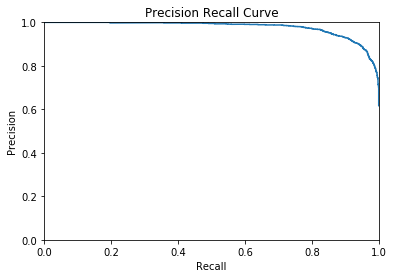

In [17]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.99185586 0.9992779  0.99995756 0.97687596 0.9999268 ]
1975 1530
[908.  90.  48.  29.  21.  21.  17.   8.  17.  12.  14.  20.  16.  11.
   7.   9.   8.   5.   9.   4.   8.   7.   5.   4.   6.   2.   7.   5.
   5.   6.   5.   7.   6.   8.   4.   5.   6.   8.   3.   7.   5.   7.
   8.   4.  15.  13.  15.  23.  22.  30.]
[  11    8    7    5    5    7    5    6    2    2    3    4    2    1
    4    4    3    7    4    2    3    0    2    6    1    1    5    4
    4    5    7    8   10    4    5    4    4    9    1    6   10   13
   14   15   22   27   35   50  109 1111]


(0, 350)

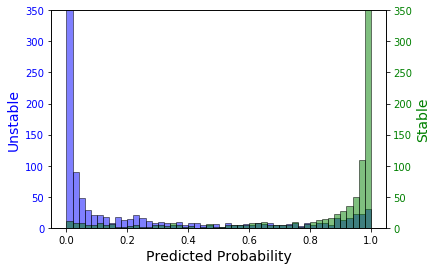

In [18]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

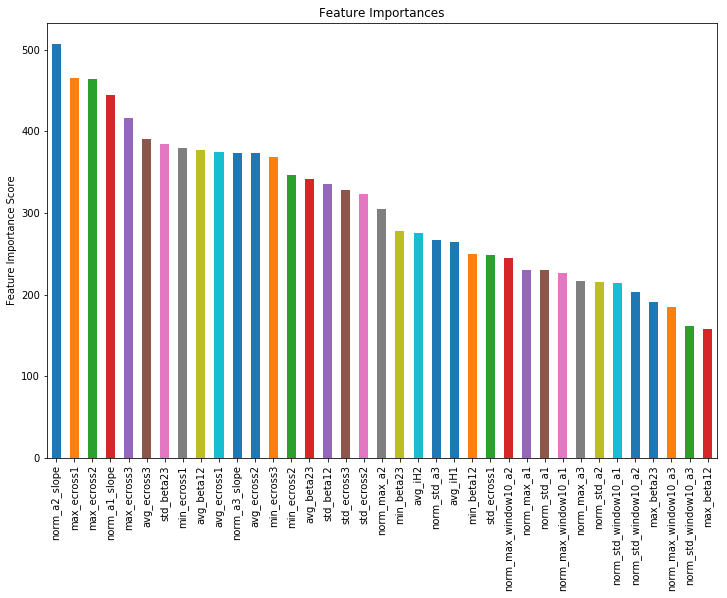

In [19]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [20]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/orbsummaryfeaturesxgb_random.pkl", "wb"))